In [ ]:
!pip install medmnist

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from glob import glob
from PIL import Image
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.utils import to_categorical, plot_model
from keras.layers import Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from medmnist import DermaMNIST

**Load DermaMNIST dataset**

In [3]:
train_data = DermaMNIST(split="train", download=True)
val_data = DermaMNIST(split="val", download=True)
test_data = DermaMNIST(split="test", download=True)

100%|██████████| 19725078/19725078 [00:02<00:00, 7879761.58it/s] 


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [4]:
x_train, y_train = train_data.imgs, train_data.labels
x_test, y_test = test_data.imgs, test_data.labels
x_val, y_val = val_data.imgs, val_data.labels

train_y = y_train
test_y = y_test
val_y = y_val

train_y=to_categorical(train_y, num_classes=7)
test_y=to_categorical(test_y, num_classes=7)
val_y=to_categorical(val_y, num_classes=7)

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
y_val = y_val.reshape(-1)

# Convert RGB images to grayscale
# x_train = np.dot(x_train[..., :3], [0.2989, 0.5870, 0.1140])
# x_test = np.dot(x_test[..., :3], [0.2989, 0.5870, 0.1140])
# x_val = np.dot(x_val[..., :3], [0.2989, 0.5870, 0.1140])

# Reshape grayscale images to add the channel dimension
# x_train = x_train.reshape(-1, 28, 28, 1)
# x_test = x_test.reshape(-1, 28, 28, 1)
# x_val = x_val.reshape(-1, 28, 28, 1)

# Ensure data type is float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

# Normalize the pixel values to the range [0, 1]
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

# Resize the image from 28x28 -> to 96x96
x_train = tf.image.resize(x_train, (96, 96))
x_val = tf.image.resize(x_val, (96, 96))
x_test = tf.image.resize(x_test, (96, 96))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (7007, 96, 96, 3) - y_train shape: (7007,)
x_val shape: (1003, 96, 96, 3) - y_val shape: (1003,)
x_test shape: (2005, 96, 96, 3) - y_test shape: (2005,)


In [5]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def plot_sample(X, y, index):
    plt.figure(figsize=(1,1))
    plt.imshow(X[index])
    plt.axis('off')  # Hide the axis
    plt.xlabel(classes[y[index]])
    plt.text(5, -2, classes[y[index]], color='black', fontsize=8)

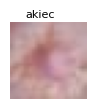

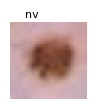

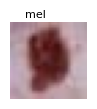

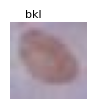

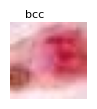

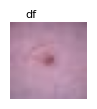

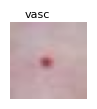

In [6]:
train_output = train_data.labels.reshape(-1, )
test_output = test_data.labels.reshape(-1, )

# 0: akiec, 8: nv, 6: mel, 16: bkl, 12: bcc, 67: df, 98: vasc
plot_sample(train_data.imgs, train_output, 0)  # 0
plot_sample(train_data.imgs, train_output, 8)  # 1
plot_sample(train_data.imgs, train_output, 6)  # 2
plot_sample(train_data.imgs, train_output, 16) # 3
plot_sample(train_data.imgs, train_output, 12) # 4
plot_sample(train_data.imgs, train_output, 67) # 5
plot_sample(train_data.imgs, train_output, 98) # 6

In [7]:
input_shape = (96, 96, 3)
num_classes = 7
input_layer = Input(shape=input_shape)

**Xception Model**

In [8]:
from keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in xception_model.layers:
    layer.trainable = True

x = xception_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_xception = tf.keras.layers.Dense(7, activation='softmax')(x)

model_xception = Model(inputs=input_layer, outputs=output_xception)

83683744/83683744 [==============================] - 5s 0us/step


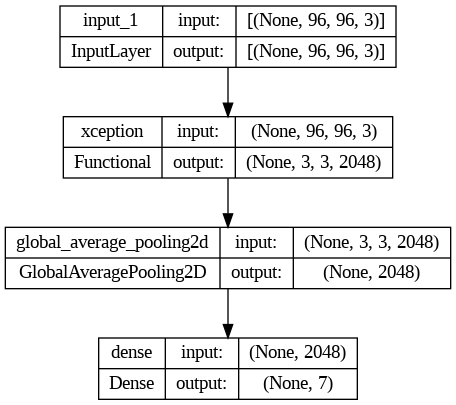

In [9]:
from keras.utils import plot_model
image_path = 'model_xception.png'
plot_model(model_xception, to_file=image_path, show_shapes=True, show_layer_names=True)

In [10]:
# Compile the model
model_xception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)   # Implement early stopping

history_xception = model_xception.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

model_xception.evaluate(x_test, y_test)

Epoch 1/30
219/219 [==============================] - 75s 133ms/step - loss: 0.8321 - accuracy: 0.7017 - val_loss: 0.9176 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - 22s 103ms/step - loss: 0.6785 - accuracy: 0.7487 - val_loss: 0.7954 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - 23s 106ms/step - loss: 0.6049 - accuracy: 0.7786 - val_loss: 0.6569 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - 24s 108ms/step - loss: 0.5292 - accuracy: 0.8109 - val_loss: 0.7839 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - 24s 109ms/step - loss: 0.4555 - accuracy: 0.8269 - val_loss: 0.7611 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 6/30
219/219 [==============================] - 24s 108ms/step - loss: 0.3582 - accuracy: 0.8728 - val_loss: 0.8733 - val_accuracy: 0.7507 - lr: 0.0010
Epoch 7/30
219/219 [==============================] 

[0.6658709645271301, 0.7581047415733337]

**InceptionResNetV2 Model**

In [11]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

inception_resnet_v2_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in inception_resnet_v2_model.layers:
    layer.trainable = True

x = inception_resnet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output_inception_resnet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_inception_resnet_v2 = Model(inputs=input_layer, outputs=output_inception_resnet_v2)

219055592/219055592 [==============================] - 10s 0us/step


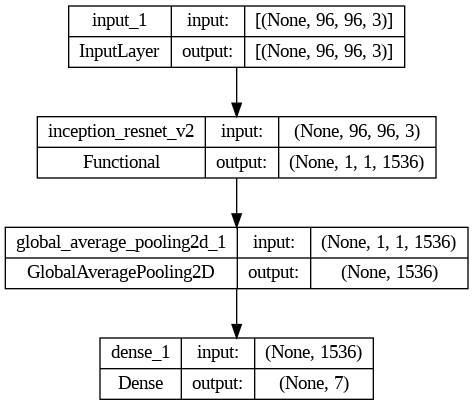

In [12]:
from keras.utils import plot_model
image_path = 'model_architecture_inception_resnet_v2.png'
plot_model(model_inception_resnet_v2, to_file=image_path, show_shapes=True, show_layer_names=True)

In [13]:
# Compile the model
model_inception_resnet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)  # Implement early stopping

history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    x_train,
    y_train,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

model_inception_resnet_v2.evaluate(x_test, y_test)

Epoch 1/30
219/219 [==============================] - 145s 244ms/step - loss: 0.9111 - accuracy: 0.6936 - val_loss: 0.8911 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 2/30
219/219 [==============================] - 32s 145ms/step - loss: 0.7221 - accuracy: 0.7363 - val_loss: 0.6583 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 3/30
219/219 [==============================] - 32s 147ms/step - loss: 0.6532 - accuracy: 0.7627 - val_loss: 1.0708 - val_accuracy: 0.7159 - lr: 0.0010
Epoch 4/30
219/219 [==============================] - 32s 148ms/step - loss: 0.7713 - accuracy: 0.7627 - val_loss: 128.5813 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - 32s 146ms/step - loss: 0.8973 - accuracy: 0.7014 - val_loss: 49.4330 - val_accuracy: 0.6012 - lr: 0.0010
Epoch 6/30
219/219 [==============================] - 32s 147ms/step - loss: 0.9189 - accuracy: 0.7153 - val_loss: 1.0666 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 7/30
219/219 [============================

[0.8176832795143127, 0.7566084861755371]

**MobileNetV2 Model**

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

for layer in mobilenet_v2_model.layers:
    layer.trainable = True

x = mobilenet_v2_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.4)(x)
output_mobilenet_v2 = tf.keras.layers.Dense(7, activation='softmax')(x)

model_mobilenet_v2 = Model(inputs=input_layer, outputs=output_mobilenet_v2)

9406464/9406464 [==============================] - 1s 0us/step


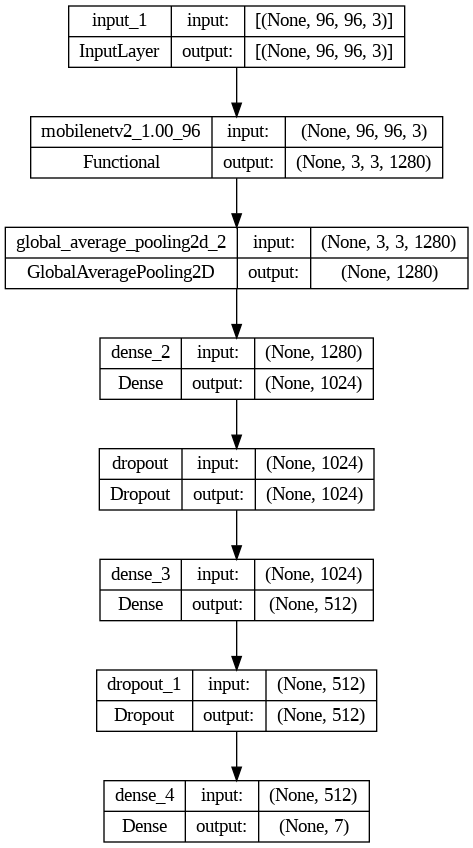

In [15]:
from keras.utils import plot_model
image_path = 'model_architecture_mobilenet_v2.png'
plot_model(model_mobilenet_v2, to_file=image_path, show_shapes=True, show_layer_names=True)

In [16]:
# Compile the model
model_mobilenet_v2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)   # Implement learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)  # Implement early stopping

history_mobilenet_v2 = model_mobilenet_v2.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[lr_scheduler, early_stopping]
)

model_mobilenet_v2.evaluate(x_test, y_test)

Epoch 1/50
219/219 [==============================] - 44s 63ms/step - loss: 0.9558 - accuracy: 0.6835 - val_loss: 10.1747 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - 10s 44ms/step - loss: 0.8188 - accuracy: 0.7149 - val_loss: 9.3487 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - 10s 44ms/step - loss: 0.7476 - accuracy: 0.7263 - val_loss: 12.4568 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - 10s 46ms/step - loss: 0.7181 - accuracy: 0.7410 - val_loss: 4.3278 - val_accuracy: 0.0239 - lr: 0.0010
Epoch 5/50
219/219 [==============================] - 10s 44ms/step - loss: 0.6870 - accuracy: 0.7463 - val_loss: 15.7774 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 6/50
219/219 [==============================] - 10s 44ms/step - loss: 0.6651 - accuracy: 0.7622 - val_loss: 14.0370 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 7/50
219/219 [==============================] - 

[1.3065754175186157, 0.7331671118736267]

**Fuzzy Rank-based Ensemble Technique**

In [17]:
#Fuzzy Rank-based Ensemble:
def generateRank1(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.exp(-((scores[i]-1)**2)/2.0)
  return rank

def generateRank2(score,class_no):
  rank = np.zeros([class_no,1])
  scores = np.zeros([class_no,1])
  scores = score
  for i in range(class_no):
      rank[i] = 1 - np.tanh(((scores[i]-1)**2)/2)
  return rank

def doFusion(res1, res2, res3, label, class_no):
    cnt = 0
    id = []
    for i in range(len(res1)):
        rank1 = generateRank1(res1[i], class_no) * generateRank2(res1[i], class_no)
        rank2 = generateRank1(res2[i], class_no) * generateRank2(res2[i], class_no)
        rank3 = generateRank1(res3[i], class_no) * generateRank2(res3[i], class_no)
        rankSum = rank1 + rank2 + rank3
        rankSum = np.array(rankSum)
        scoreSum = 1 - (res1[i] + res2[i] + res3[i]) / 3
        scoreSum = np.array(scoreSum)

        fusedScore = (rankSum.T) * scoreSum
        cls = np.argmin(rankSum)
        if cls<class_no and label[i][cls]== 1:  # Compare indices directly
            cnt += 1
        id.append(cls)
    print(cnt / len(res1))
    return id

In [18]:
pred_xception = model_xception.predict(x_test)
pred_inception_resnet_v2 = model_inception_resnet_v2.predict(x_test)
pred_mobilenet_v2 = model_mobilenet_v2.predict(x_test)
pred_ensembled = doFusion(pred_xception, pred_inception_resnet_v2, pred_mobilenet_v2, test_y, class_no=num_classes)

63/63 [==============================] - 2s 12ms/step
0.7825436408977556


**Evaluation with Classification Report**

In [19]:
label_xception = np.argmax(pred_xception, axis=-1)
label_inception_resnet_v2 = np.argmax(pred_inception_resnet_v2, axis=-1)
label_mobilenet_v2 = np.argmax(pred_mobilenet_v2, axis=-1)

print('Xception base learner')
print(classification_report(y_test, label_xception, target_names=classes, digits=4))
print('InceptionResNetV2 base learner')
print(classification_report(y_test, label_inception_resnet_v2, target_names=classes, digits=4))
print('MobileNetV2 base learner')
print(classification_report(y_test, label_mobilenet_v2, target_names=classes, digits=4))
print('Ensembled')
print(classification_report(y_test, pred_ensembled, target_names=classes, digits=4))

Xception base learner
              precision    recall  f1-score   support

       akiec     0.4821    0.4091    0.4426        66
         bcc     0.5472    0.5631    0.5550       103
         bkl     0.5045    0.5045    0.5045       220
          df     0.0000    0.0000    0.0000        23
         mel     0.4766    0.4574    0.4668       223
          nv     0.8784    0.8941    0.8862      1341
        vasc     0.5227    0.7931    0.6301        29

    accuracy                         0.7581      2005
   macro avg     0.4874    0.5173    0.4979      2005
weighted avg     0.7474    0.7581    0.7522      2005

InceptionResNetV2 base learner
              precision    recall  f1-score   support

       akiec     0.4648    0.5000    0.4818        66
         bcc     0.4862    0.5146    0.5000       103
         bkl     0.5368    0.4636    0.4976       220
          df     0.6429    0.3913    0.4865        23
         mel     0.5060    0.3767    0.4319       223
          nv     0.8605  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Evaluation with Confusion Matrix**

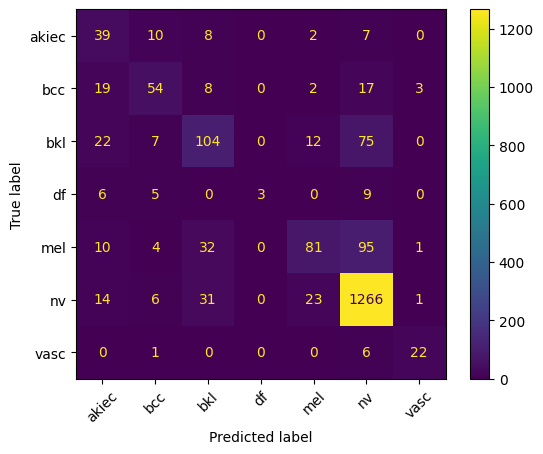

In [20]:
cm_ensembled = confusion_matrix(y_test, pred_ensembled)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensembled, display_labels=classes)
disp.plot(xticks_rotation=45)

**Generate ACC & Loss Curve**

In [21]:
def show_plots(history):
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["loss"], color="green", label="Train Loss")
  plt.plot(history.epoch, history.history["val_loss"], color="blue",
  label="Validation Loss")
  plt.xlabel("Epoch Number")
  plt.ylabel("Loss")
  plt.legend()
  plt.title("Loss Graph")
  plt.show()
  plt.subplots(figsize=(6,4))
  plt.plot(history.epoch, history.history["accuracy"], color="green",
  label="Train Accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], color="blue",
  label="Validation Accuracy")
  plt.xlabel("Epoch Number")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.title("Accuracy Graph")
  plt.show()

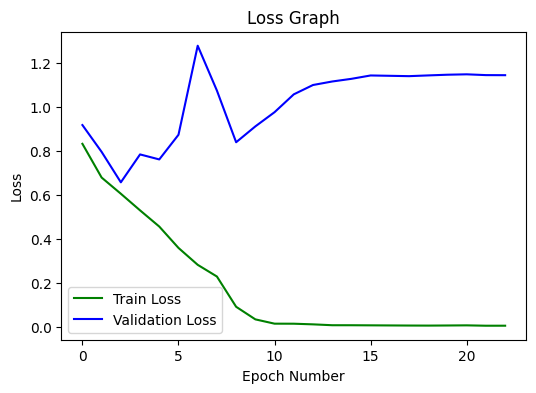

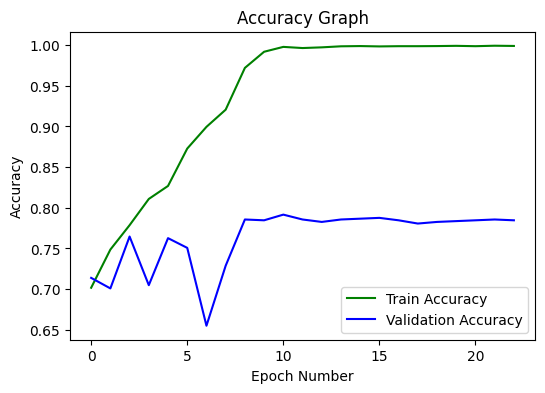

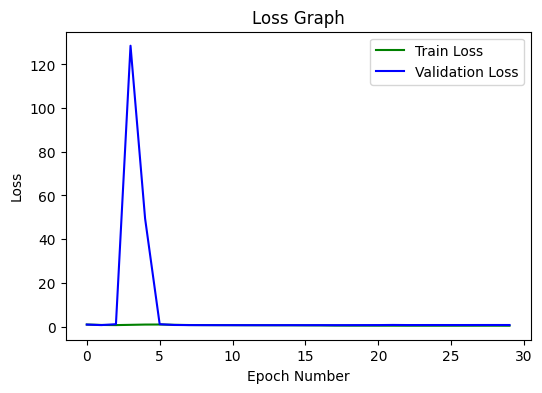

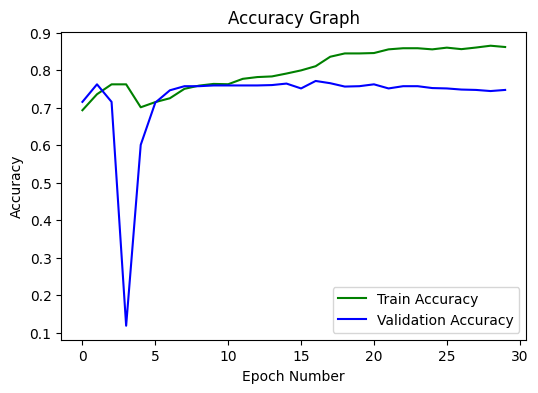

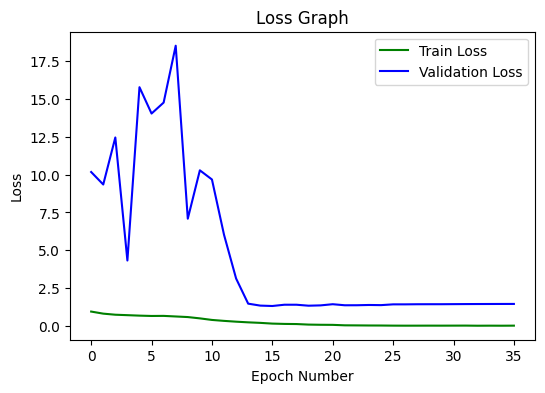

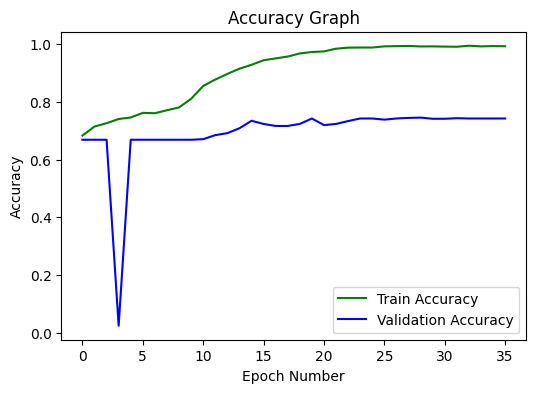

In [22]:
show_plots(history_xception)
show_plots(history_inception_resnet_v2)
show_plots(history_mobilenet_v2)